In [1]:
import glob
import logging
import os
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
class Camera(object):
    def __init__(self):
        self._mtx = None
        self._dist = None

    def calibration(self):
        nx, ny = 9, 6
        object_points = []
        image_points = []
        image_size = None
        objp = np.zeros((nx*ny, 3), dtype=np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        for img_file in glob.glob('camera_cal/*'):
            img = cv2.imread(img_file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            image_size = gray.shape[::-1]
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
            if ret:
                image_points.append(corners)
                object_points.append(objp)
            else:
                logging.warning("Cannot find chessboard corners for image: %s", img_file)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            object_points, image_points, image_size, None, None)
        self._mtx = mtx
        self._dist = dist
    
    def undistort(self, img):
        return cv2.undistort(img, self._mtx, self._dist, None, self._mtx)

In [3]:
camera = Camera()
camera.calibration()

True

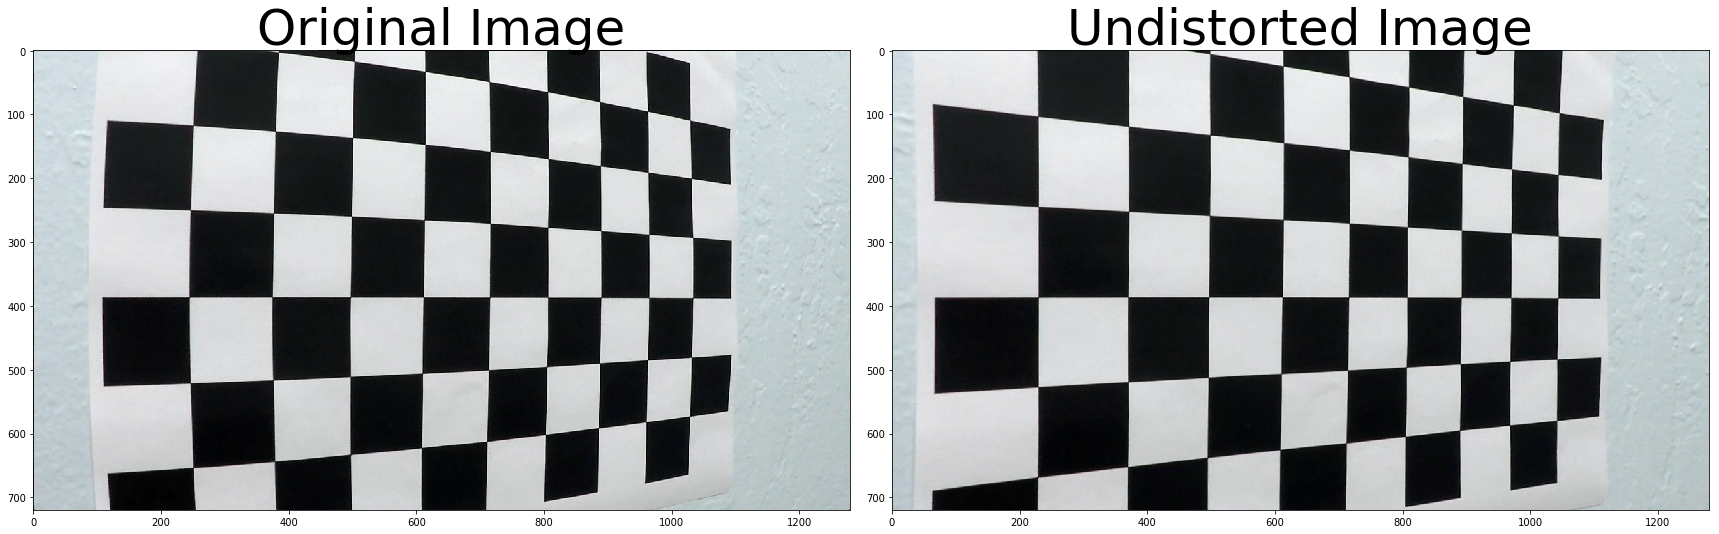

In [4]:
# Inspect the output of distortion correction.
raw_img = cv2.imread('camera_cal/calibration5.jpg')
undist_img = camera.undistort(raw_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)
cv2.imwrite('undistorted_cal5.jpg', undist_img)

True

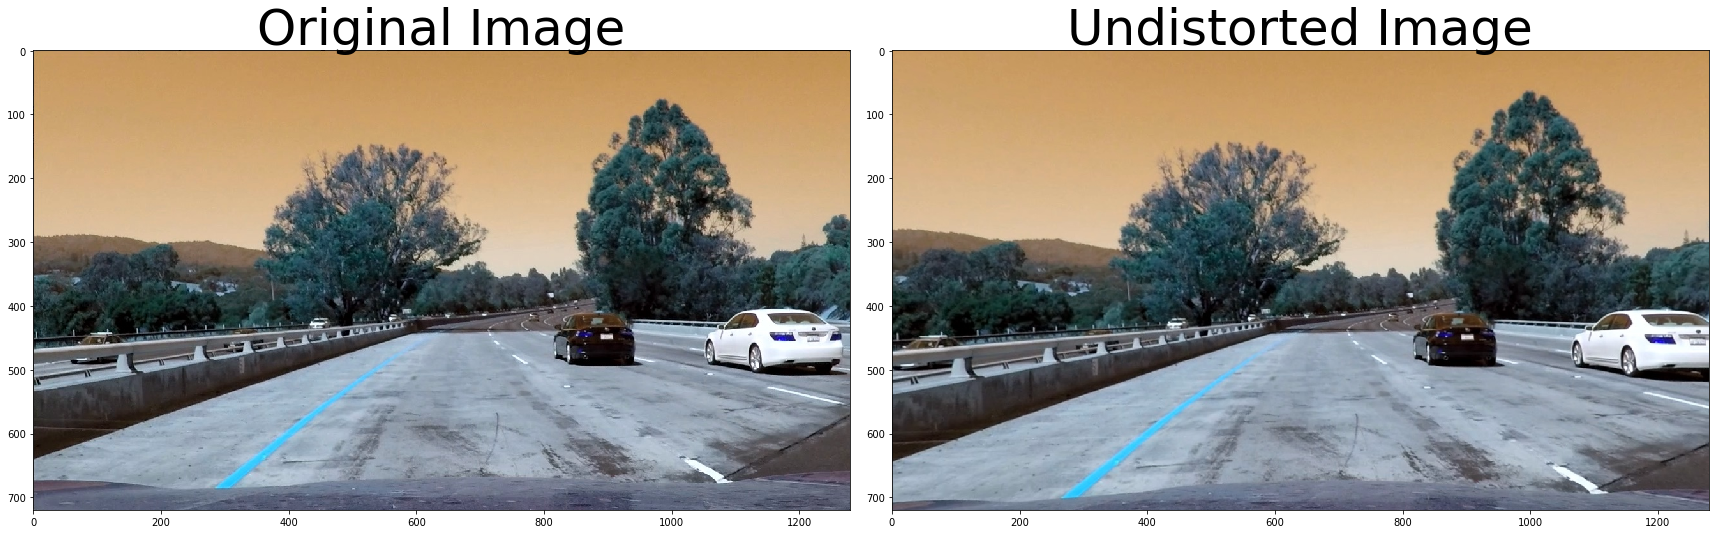

In [5]:
raw_img = cv2.imread('test_images/test1.jpg')
undist_img = camera.undistort(raw_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)
cv2.imwrite('undistorted_test1.jpg', undist_img)

True

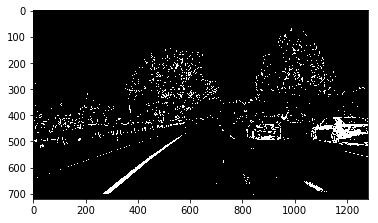

In [6]:
def color_filter(img, debug=False):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > 160)] = 1
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    x_binary = np.zeros_like(gray)
    x_binary[(scaled_sobel > 40)] = 1
    if debug:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        ax1.imshow(s_binary, cmap='gray')
        ax2.imshow(x_binary, cmap='gray')
    s_binary[(s_binary == 1) | (x_binary == 1)] = 1
    return s_binary

#img = cv2.imread('project_video_frames/frame-1047.jpg')
#img = cv2.imread('test_images/test1.jpg')
#color_filter(img, True)
binary_image = color_filter(undist_img)
plt.imshow(binary_image, cmap='gray')
cv2.imwrite('binary.jpg', binary_image.astype('uint8') * 255)

True

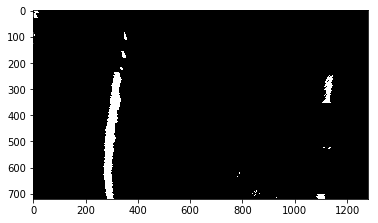

In [7]:
class PerspectiveTransformer(object):
    def __init__(self):
        img = cv2.imread('test_images/straight_lines1.jpg')
        #plt.imshow(img)
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # Manualy pick four locations in the origin image
        self._img_size = (img.shape[1], img.shape[0])
        src = np.float32(
            [[240, 686],
             [576, 460],
             [704, 460],
             [1040, 686]])
        dst = np.float32(
            [[240, 720],
             [240, 0],
             [1040, 0],
             [1040, 720]])
        self._M = cv2.getPerspectiveTransform(src, dst)
        self._Minv = cv2.getPerspectiveTransform(dst, src)
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/(1040-240) # meters per pixel in x dimension
    
    def transform(self, img):
        return cv2.warpPerspective(img, self._M, self._img_size, flags=cv2.INTER_LINEAR)

    def inv_transform(self, img):
        return cv2.warpPerspective(img, self._Minv, self._img_size, flags=cv2.INTER_LINEAR)

perspective_transformer = PerspectiveTransformer()

warped_image = perspective_transformer.transform(binary_image)
plt.imshow(warped_image, cmap='gray')
cv2.imwrite('warped.jpg', warped_image.astype('uint8') * 255)

In [8]:
# Define a class to receive the characteristics of each line detection
class Line(object):
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') # Not used
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

class LineDetector(object):
    def __init__(self):
        #self.camera = Camera()
        #self.camera.calibration()
        self.camera = camera
        self.perspective_transformer = PerspectiveTransformer()
        self.left_line = Line()
        self.right_line = Line()

    def fit_lane_lines(self, binary_img, margin=100, nwindows=9, minpix=50):
        nonzero = binary_img.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        out_img = np.dstack((binary_img, binary_img, binary_img))*255

        left_lane_inds = []
        right_lane_inds = []

        img_height, img_width = binary_img.shape
        win_height = np.int(img_height // nwindows)
        histogram = np.sum(binary_img[img_height//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        if not self.left_line.detected:
            for window in range(nwindows):
                win_y_low = img_height-(window+1)*win_height
                win_y_high = img_height-window*win_height
                win_xleft_low, win_xleft_high = leftx_base-margin, leftx_base+margin

                #cv2.rectangle(out_img,
                #              (win_xleft_low,win_y_low),
                #              (win_xleft_high,win_y_high),
                #              (0,255,0),
                #              5)

                # Find indices within the window range.
                good_left_inds = ((nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)
                                  & (nonzeroy > win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                if len(good_left_inds) > minpix:
                    #print('update left_base for window %d', window)
                    leftx_base = np.int(np.median(nonzerox[good_left_inds]))
            
            left_lane_inds = np.concatenate(left_lane_inds)
        else:
            current_fit = self.left_line.best_fit
            left_lane_inds = (
                (nonzerox > current_fit[0]*nonzeroy**2+current_fit[1]*nonzeroy+current_fit[2]-margin)
                & (nonzerox < current_fit[0]*nonzeroy**2+current_fit[1]*nonzeroy+current_fit[2]+margin)).nonzero()[0]
        
        if not self.right_line.detected:
            for window in range(nwindows):
                win_y_low = img_height-(window+1)*win_height
                win_y_high = img_height-window*win_height
                win_xright_low, win_xright_high = rightx_base-margin, rightx_base+margin

                #cv2.rectangle(out_img,
                #              (win_xright_low,win_y_low),
                #              (win_xright_high,win_y_high),
                #              (0,255,0),
                #              5)

                # Find indices within the window range.
                good_right_inds = ((nonzerox > win_xright_low) & (nonzerox < win_xright_high)
                                  & (nonzeroy > win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

                # Append these indices to the lists
                right_lane_inds.append(good_right_inds)
                if len(good_right_inds) > minpix:
                    #print('update right_base for window %d', window)
                    rightx_base = np.int(np.median(nonzerox[good_right_inds]))
            
            right_lane_inds = np.concatenate(right_lane_inds)
        else:
            current_fit = self.right_line.best_fit
            right_lane_inds = (
                (nonzerox > current_fit[0]*nonzeroy**2+current_fit[1]*nonzeroy+current_fit[2]-margin)
                & (nonzerox < current_fit[0]*nonzeroy**2+current_fit[1]*nonzeroy+current_fit[2]+margin)).nonzero()[0]

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        self.left_line.current_fit = left_fit
        self.right_line.current_fit = right_fit
        self.left_line.detected = True
        self.right_line.detected = True
        
        if self.left_line.best_fit is None:
            self.left_line.best_fit = self.left_line.current_fit
        else:
            self.left_line.best_fit = 0.9*self.left_line.best_fit+0.1*self.left_line.current_fit
            
        if self.right_line.best_fit is None:
            self.right_line.best_fit = self.right_line.current_fit
        else:
            self.right_line.best_fit = 0.9*self.right_line.best_fit+0.1*self.right_line.current_fit
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_height-1, img_height)
        left_fitx = self.left_line.best_fit[0]*ploty**2 + self.left_line.best_fit[1]*ploty + self.left_line.best_fit[2]
        right_fitx = self.right_line.best_fit[0]*ploty**2 + self.right_line.best_fit[1]*ploty + self.right_line.best_fit[2]

        self.left_line.allx = left_fitx
        self.left_line.ally = ploty
        self.right_line.allx = right_fitx
        self.right_line.ally = ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        return left_fitx, right_fitx, ploty, out_img

    def find_lane_lines(self, raw_img):
        undist_img = self.camera.undistort(raw_img)
        binary_img = color_filter(undist_img)
        warped = self.perspective_transformer.transform(binary_img)
        left_fitx, right_fitx, ploty, out_img = line_detector.fit_lane_lines(warped)
        line_img = np.zeros_like(out_img)
        region_left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        region_right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        region_pts = np.hstack((region_left_line, region_right_line))
        cv2.fillPoly(line_img, np.int_([region_pts]), (200, 200, 0))
        #return left_fitx, right_fitx, ploty, cv2.addWeighted(out_img, 1, line_img, 0.3, 0)
        inversed_line_img = self.perspective_transformer.inv_transform(line_img)
        roc, dist = self.meature_curvature()
        if dist > 0:
            text = "RoC: %d (m), Car is %.2f (m) to the left" % (roc, dist)
        else:
            text = "RoC: %d (m), Car is %.2f (m) to the right" % (roc, np.fabs(dist))
        cv2.putText(raw_img,
                    text,  
                    (100, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1.5,
                    (255,255,255),
                    5)
        return cv2.addWeighted(raw_img, 1, inversed_line_img, 0.6, 0)
    
    def meature_curvature(self):
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        left_fit_cr=np.polyfit(self.perspective_transformer.ym_per_pix*self.left_line.ally,
                               self.perspective_transformer.xm_per_pix*self.left_line.allx,
                               2)
        right_fit_cr=np.polyfit(self.perspective_transformer.ym_per_pix*self.right_line.ally,
                                self.perspective_transformer.xm_per_pix*self.right_line.allx,
                                2)
        y_eval = np.max(self.left_line.ally)
        self.left_line.radius_of_curvature = np.power(
            1+np.square(2*left_fit_cr[0]*y_eval+left_fit_cr[1]),1.5)/np.fabs(2*left_fit_cr[0])
        self.right_line.radius_of_curvature = np.power(
            1+np.square(2*right_fit_cr[0]*y_eval+right_fit_cr[1]),1.5)/np.fabs(2*right_fit_cr[0])
        
        self.left_line.line_base_pos = (640 - self.left_line.allx[0])*self.perspective_transformer.xm_per_pix
        self.right_line.line_base_pos = (self.right_line.allx[0] - 640)*self.perspective_transformer.xm_per_pix
        return ((self.left_line.radius_of_curvature+self.right_line.radius_of_curvature)/2,
                (self.right_line.line_base_pos-self.left_line.line_base_pos)/2)



In [9]:
line_detector = LineDetector()

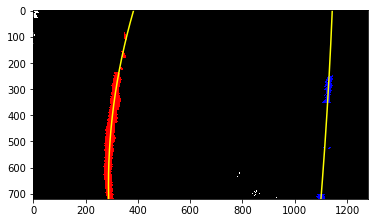

In [10]:
left_fitx, right_fitx, ploty, out_img = line_detector.fit_lane_lines(warped_image)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [11]:
raw_img = cv2.imread('test_images/test1.jpg')
lane_area_img = line_detector.find_lane_lines(raw_img)
cv2.imwrite('lane_area_img.jpg', lane_area_img)

True

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [13]:
line_detector = LineDetector()
nframe = 1
def save_frames_for_inspection(img):
    global nframe
    out_img = line_detector.find_lane_lines(img)
    cv2.imwrite('project_video_frames/out-frame-%d.jpg' % nframe, cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    nframe += 1
    return out_img

In [14]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(save_frames_for_inspection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:36<00:00, 12.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 51s, sys: 27.3 s, total: 2min 19s
Wall time: 1min 37s
